Geopolitical Tail Risk Model
Non-Stationary POT EVT Framework with Optimal Lag - Complete Implementation
Initializing model...
GPR stabilization: original range [-0.9500, 9.4321]
                  standardized range [-0.5002, 20.0145]
Data loaded: 2277 observations, period: 2015-06-25 00:00:00 to 2025-05-30 00:00:00
Analyzing indices: 12 indices
GPR data numerically stabilized

Running complete analysis...
Multi-Index Geopolitical Tail Risk Analysis
Non-Stationary POT EVT Framework with Optimal Lag

==================== Analyzing HSI_return ====================
Stage 1: Threshold selection
Selected threshold u=0.0132, Nu=340, initial xi_hat=0.4233
Stage 2: Optimal lag selection
Optimal lag k=1, AIC=-2567.1753
Stage 3: Final parameter estimation
Final GPD parameters: sigma0=-4.9208, sigma1=0.0367, xi0=0.1382, xi1=-0.0620
Log-likelihood: 1287.1261, Uncond LL: 1286.9223, LR p-value: 0.8156
AIC full: -2566.2523, AIC uncond: -2569.8447

==================== Analyzing SH_return =============

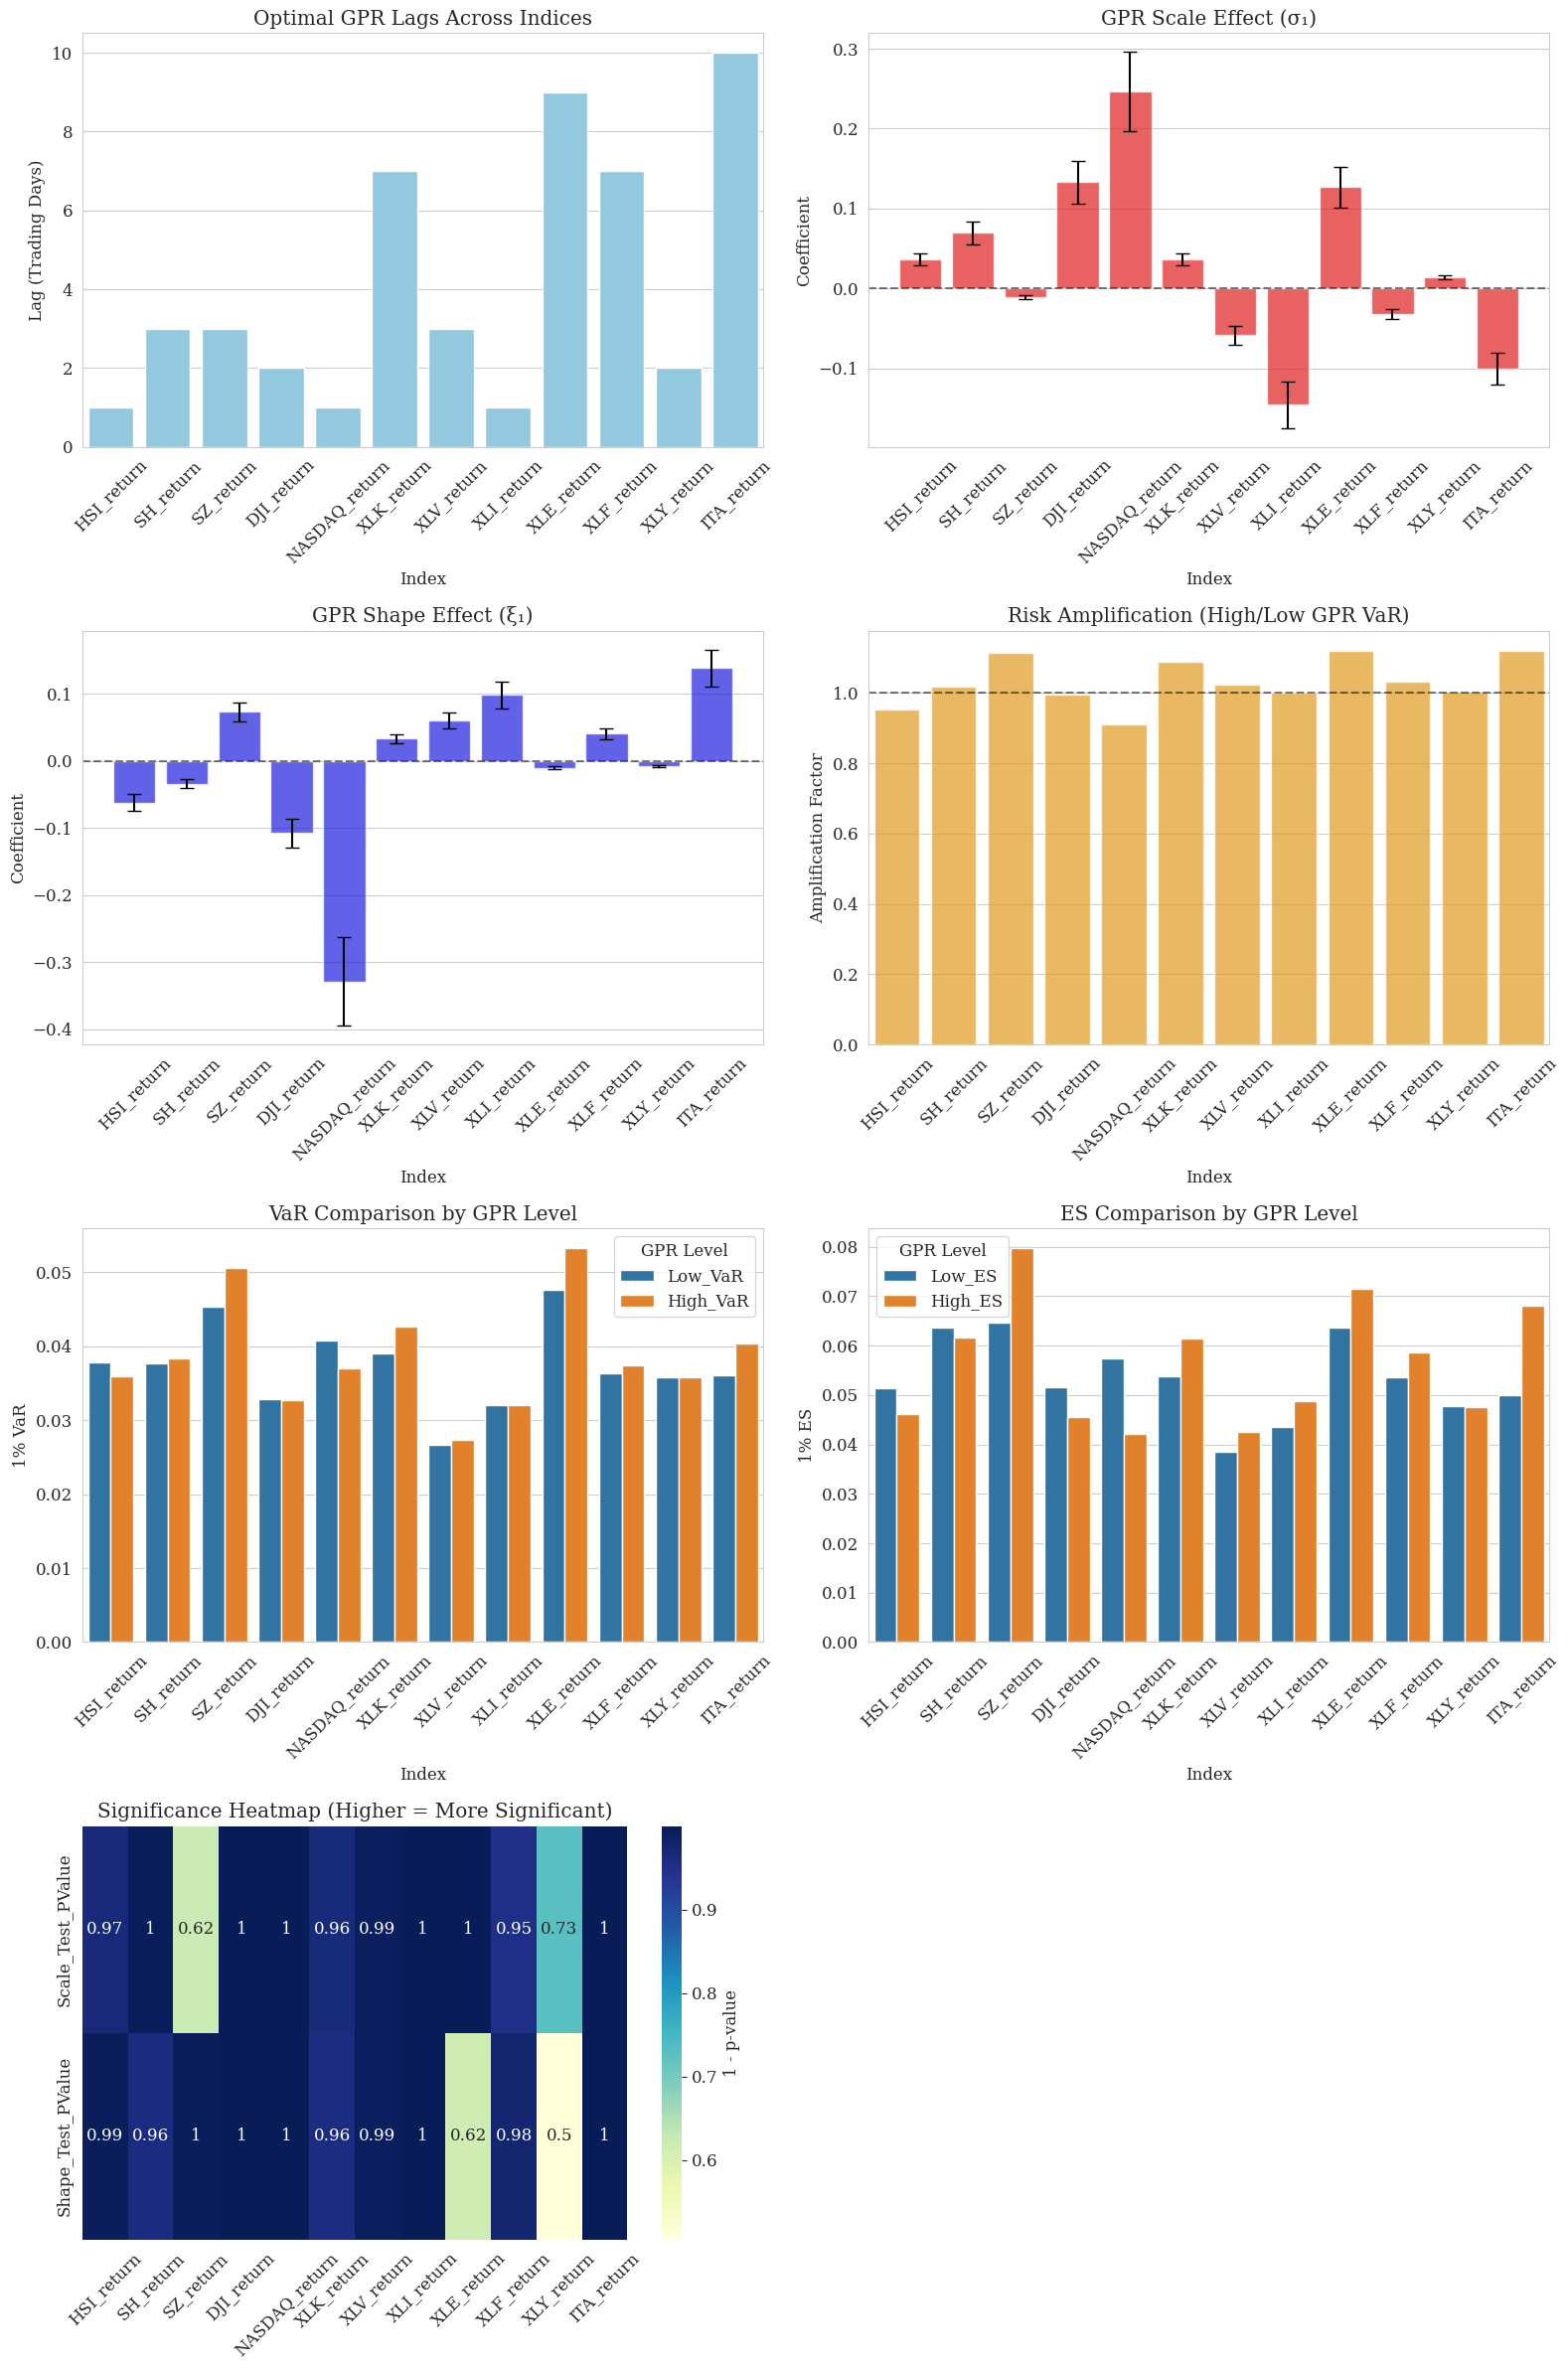

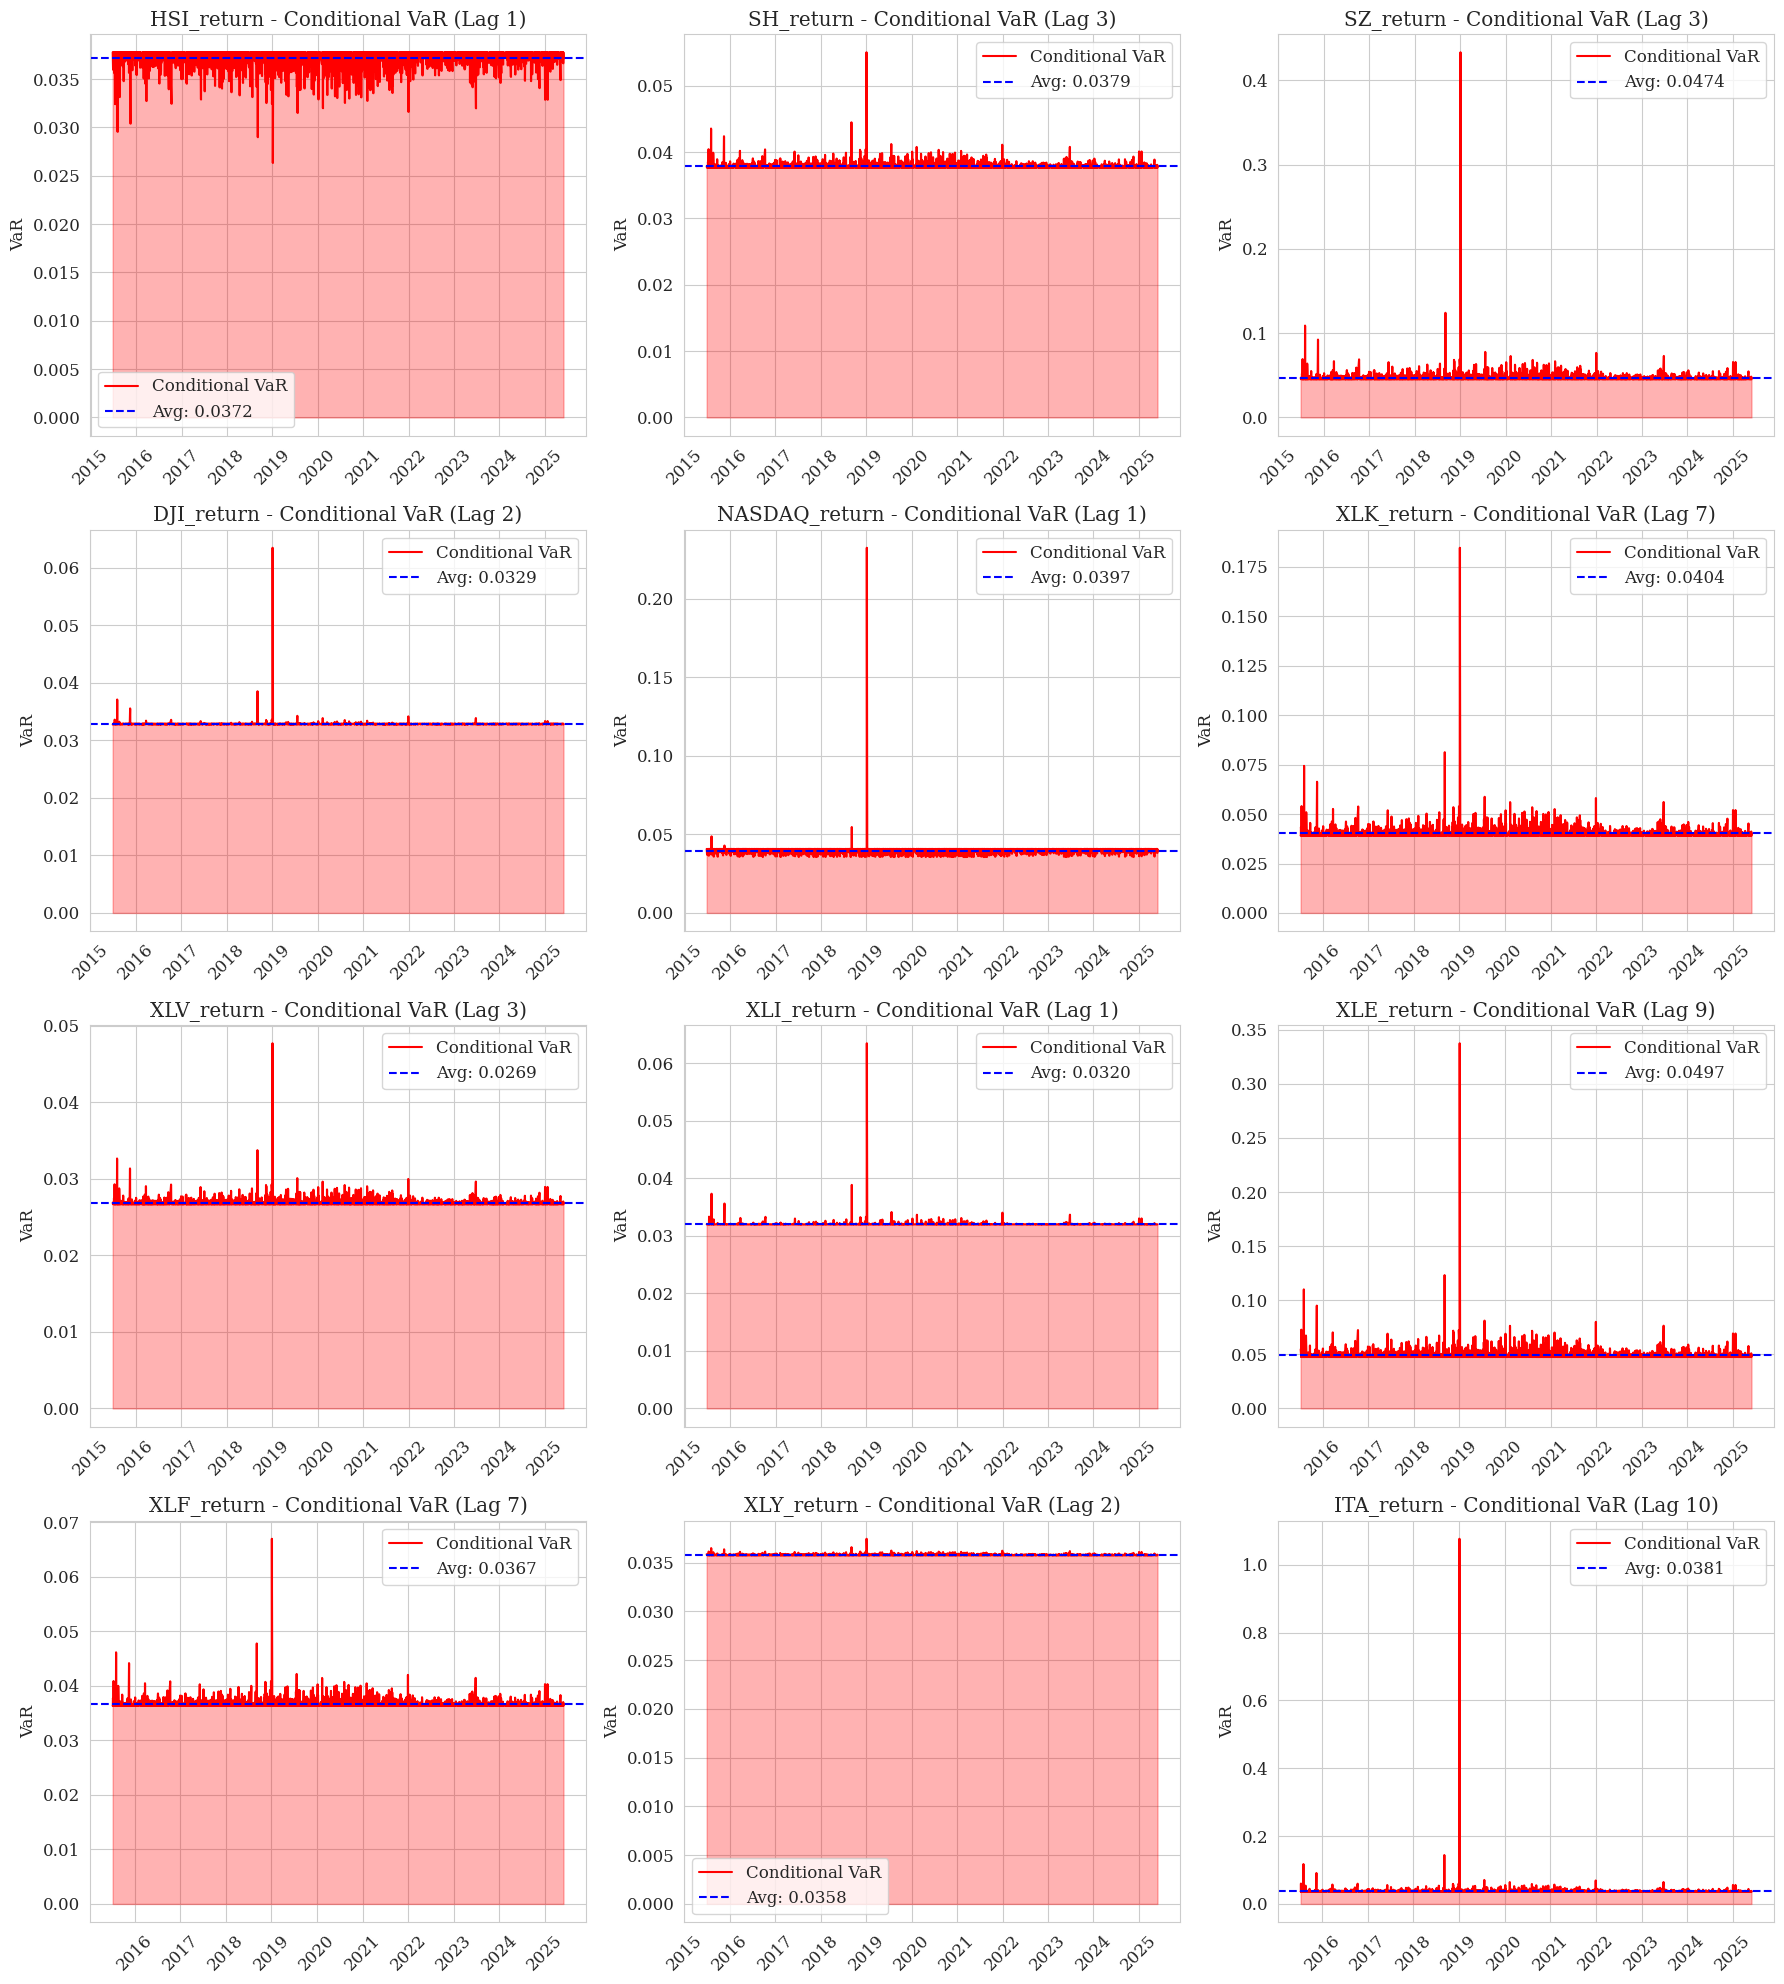


Generating comprehensive report...

Geopolitical Tail Risk Model - Comprehensive Analysis Report
Non-Stationary POT EVT Framework with Optimal Lag Complete Results

1. Dataset Overview:
   • Total observations: 2277
   • Time period: 2015-06-25 00:00:00 to 2025-05-30 00:00:00
   • Analyzed indices: 12
   • GPR raw range: -0.95 to 9.43
   • GPR processed range: -0.50 to 20.01

2. Core Hypotheses Validation:
   • Hypothesis 1 (σ₁ > 0): 7/12 indices satisfied
   • Hypothesis 2 (ξ₁ > 0): 6/12 indices satisfied

3. Optimal Lag Summary:
   • Average optimal lag: 4.08 trading days
   1. ITA_return: lag = 10
   2. XLE_return: lag = 9
   3. XLK_return: lag = 7
   4. XLF_return: lag = 7
   5. SH_return: lag = 3

4. GPR Scale Effect Ranking (σ₁ coefficient):
   1. NASDAQ_return: σ₁ = 0.2467*** (p = 0.0000, lag = 1)
   2. DJI_return: σ₁ = 0.1330*** (p = 0.0003, lag = 2)
   3. XLE_return: σ₁ = 0.1269*** (p = 0.0003, lag = 9)
   4. SH_return: σ₁ = 0.0695*** (p = 0.0036, lag = 3)
   5. HSI_return: σ

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, optimize
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

class MultiIndexGeopoliticalTailRiskModel:
    """
    Multi-Index Geopolitical Tail Risk Model using Non-Stationary POT EVT
    Three-Stage Estimation Framework with Optimal Lag Selection
    """
    
    def __init__(self, data_path):
        """Initialize model, load data and preprocess GPR"""
        self.data = pd.read_csv(data_path)
        self.data['date'] = pd.to_datetime(self.data['date'])
        
        # Extract all return columns
        self.return_columns = ['HSI_return', 'SH_return', 'SZ_return', 'DJI_return', 
                              'NASDAQ_return', 'XLK_return', 'XLV_return', 'XLI_return', 
                              'XLE_return', 'XLF_return', 'XLY_return', 'ITA_return']
        
        # GPR data processing: numerical stabilization
        self.gpr_raw = self.data['GPR'].values
        self.gpr_processed = self.numerical_stabilization_gpr(self.gpr_raw)
        self.T = len(self.gpr_processed)
        self.results = {}
        
        print(f"Data loaded: {self.T} observations, period: {self.data['date'].min()} to {self.data['date'].max()}")
        print(f"Analyzing indices: {len(self.return_columns)} indices")
        print(f"GPR data numerically stabilized")
    
    def numerical_stabilization_gpr(self, gpr_data):
        """GPR numerical stabilization processing """
        gpr_positive = np.maximum(gpr_data, 1e-6)
        gpr_mean, gpr_std = np.mean(gpr_positive), np.std(gpr_positive)
        gpr_standardized = (gpr_positive - gpr_mean) / gpr_std
        
        print(f"GPR stabilization: original range [{gpr_data.min():.4f}, {gpr_data.max():.4f}]")
        print(f"                  standardized range [{gpr_standardized.min():.4f}, {gpr_standardized.max():.4f}]")
        return gpr_standardized
    
    def analyze_single_index(self, index_name):
        """Analyze geopolitical tail risk for single index using non-stationary POT with optimal lag"""
        print(f"\n{'='*20} Analyzing {index_name} {'='*20}")
        
        returns = self.data[index_name].values
        dates = self.data['date'].values
        losses = -returns
        T = len(losses)
        
        # Stage 1: Threshold selection
        u, xi_hat_initial, Nu = self.stage1_threshold_selection(losses, T)
        
        # Stage 2: Optimal lag selection
        optimal_k, best_aic, best_params_temp, best_ll = self.stage2_optimal_lag_selection(losses, u, Nu, T)
        
        # Stage 3: Final parameter estimation with optimal lag
        gpr_cov_opt = np.roll(self.gpr_processed, -optimal_k)[: -optimal_k]
        losses_opt = losses[optimal_k:]
        dates_opt = dates[optimal_k:]
        T_opt = len(losses_opt)
        Nu_opt = np.sum(losses_opt > u)  # Recalculate Nu for aligned data
        
        params_stage3, ll, ll_uncond, lr_stat, p_lr, aic_full, aic_uncond = self.stage3_final_estimation(losses_opt, gpr_cov_opt, u, Nu_opt)
        
        # Calculate risk measures
        risk_measures = self.calculate_risk_measures(params_stage3, u, Nu_opt, T_opt, gpr_cov_opt)
        
        # Hypothesis testing with heuristic SE (simplified for stability)
        hypothesis_tests = self.hypothesis_tests(params_stage3)
        
        # Store results
        self.results[index_name] = {
            'stage1': {'u': u, 'Nu': Nu_opt, 'xi_hat_initial': xi_hat_initial},
            'optimal_lag': optimal_k,
            'stage3': params_stage3,
            'll': ll, 'll_uncond': ll_uncond, 'lr_p': p_lr, 'aic_full': aic_full, 'aic_uncond': aic_uncond,
            'risk_measures': risk_measures, 'hypothesis_tests': hypothesis_tests, 
            'losses': losses_opt, 'gpr_cov': gpr_cov_opt, 'dates': dates_opt
        }
        
        return self.results[index_name]
    
    def hill_estimator(self, data_sorted_desc, k):
        """Hill estimator for tail index"""
        if k < 2:
            return 0.0
        logs = np.log(data_sorted_desc[:k] / data_sorted_desc[k - 1])
        return np.mean(logs)
    
    def stage1_threshold_selection(self, losses, T):
        """Stage 1: Threshold selection using bootstrap MSE of Hill estimator"""
        print("Stage 1: Threshold selection")
        
        losses_sorted = np.sort(losses)[::-1]
        k_min = max(10, int(T * 0.02))
        k_max = min(int(T * 0.15), T - 1)
        k_values = np.unique(np.linspace(k_min, k_max, 10, dtype=int))
        
        mse_list = []
        xi_hats = []
        
        for k in k_values:
            xi_hat = self.hill_estimator(losses_sorted, k)
            xi_hats.append(xi_hat)
            
            # Bootstrap for MSE
            B = 200
            xi_b = []
            for _ in range(B):
                resample = np.random.choice(losses, T, replace=True)
                res_sorted = np.sort(resample)[::-1]
                xi_b.append(self.hill_estimator(res_sorted, k))
            xi_b = np.array(xi_b)
            bias = np.mean(xi_b) - xi_hat
            var = np.var(xi_b)
            mse = bias**2 + var
            mse_list.append(mse)
        
        opt_idx = np.argmin(mse_list)
        k_opt = k_values[opt_idx]
        xi_hat = xi_hats[opt_idx]
        u = losses_sorted[k_opt - 1]
        
        if xi_hat < 0 or k_opt < 30:
            u = np.percentile(losses, 90)
            k_opt = int(T * 0.1)
            xi_hat = self.hill_estimator(np.sort(losses)[::-1], k_opt)
        
        Nu = np.sum(losses > u)
        
        if Nu < 10:
            u = np.percentile(losses, 85)
            Nu = np.sum(losses > u)
            xi_hat = self.hill_estimator(np.sort(losses)[::-1], Nu)
        
        print(f"Selected threshold u={u:.4f}, Nu={Nu}, initial xi_hat={xi_hat:.4f}")
        
        return u, xi_hat, Nu
    
    def gpd_fit(self, excesses, cov_exc):
        """Fit non-stationary GPD and return params, ll, aic"""
        if len(excesses) < 10:
            return {'sigma0': 0.0, 'sigma1': 0.0, 'xi0': 0.1, 'xi1': 0.0}, -np.inf, np.inf
        
        # Unconditional for initial
        def gpd_negll_uncond(par, y):
            xi, logsigma = par
            sigma = np.exp(logsigma)
            if sigma <= 0:
                return 1e10
            z = 1 + xi * y / sigma
            if np.any(z <= 0):
                return 1e10
            if abs(xi) < 1e-6:
                return len(y) * np.log(sigma) + np.sum(y / sigma)
            else:
                return len(y) * np.log(sigma) + (1 + 1 / xi) * np.sum(np.log(z))
        
        initial_uncond = [0.1, np.log(np.std(excesses) + 1e-6)]
        res_uncond = optimize.minimize(gpd_negll_uncond, initial_uncond, args=(excesses,), bounds=[(-0.5, 0.5), (None, None)], method='L-BFGS-B')
        if not res_uncond.success:
            res_uncond = optimize.minimize(gpd_negll_uncond, initial_uncond, args=(excesses,), method='TNC')
        
        if res_uncond.success:
            xi_u, logsigma_u = res_uncond.x
        else:
            xi_u = 0.1
            logsigma_u = np.log(np.std(excesses) + 1e-6)
        
        # Non-stationary negll
        def nonstat_negll(par, y, cov):
            sigma0, sigma1, xi0, xi1 = par
            sigma = np.exp(sigma0 + sigma1 * cov)
            xi = xi0 + xi1 * cov
            bad = (sigma <= 0) | (1 + xi * y / sigma <= 0)
            if np.any(bad):
                return 1e10
            term = np.log(sigma) + (1 + 1 / xi) * np.log(1 + xi * y / sigma)
            term[np.abs(xi) < 1e-6] = np.log(sigma[np.abs(xi) < 1e-6]) + y[np.abs(xi) < 1e-6] / sigma[np.abs(xi) < 1e-6]
            return np.sum(term)
        
        initial = [logsigma_u, 0.0, xi_u, 0.0]
        bounds = [(-10, 10), (-5, 5), (-0.5, 1.0), (-1, 1)]
        
        initials = [
            initial,
            [logsigma_u, 0.1, xi_u, 0.1],
            [logsigma_u, -0.1, xi_u, -0.1]
        ]
        
        best_ll = np.inf
        best_params = None
        
        for init in initials:
            res = optimize.minimize(nonstat_negll, init, args=(excesses, cov_exc), bounds=bounds, method='L-BFGS-B', tol=1e-8)
            if not res.success:
                res = optimize.minimize(nonstat_negll, init, args=(excesses, cov_exc), bounds=bounds, method='TNC', tol=1e-8)
            
            if res.success and res.fun < best_ll:
                best_ll = res.fun
                best_params = res.x
        
        if best_params is None:
            # Fallback to unconditional with sigma1=xi1=0
            best_params = [logsigma_u, 0.0, xi_u, 0.0]
            best_ll = -nonstat_negll(best_params, excesses, cov_exc)
        
        params = best_params
        ll = -best_ll
        aic = -2 * ll + 8
        
        params_dict = {'sigma0': params[0], 'sigma1': params[1], 'xi0': params[2], 'xi1': params[3]}
        
        return params_dict, ll, aic
    
    def stage2_optimal_lag_selection(self, losses, u, Nu, T):
        """Stage 2: Optimal lag selection using AIC"""
        print("Stage 2: Optimal lag selection")
        
        candidate_lags = range(1, 11)  # Restricted to 1-10 for stability
        aic_values = []
        params_list = []
        ll_values = []
        
        for k in candidate_lags:
            if k >= T - 30:
                continue
            gpr_cov_k = self.gpr_processed[:-k]
            losses_k = losses[k:]
            idx_exc_k = losses_k > u
            excesses_k = losses_k[idx_exc_k] - u
            cov_exc_k = gpr_cov_k[idx_exc_k]
            
            if len(excesses_k) < 10:
                aic_values.append(np.inf)
                params_list.append(None)
                ll_values.append(-np.inf)
                continue
            
            params_k, ll_k, aic_k = self.gpd_fit(excesses_k, cov_exc_k)
            aic_values.append(aic_k)
            params_list.append(params_k)
            ll_values.append(ll_k)
        
        if all(np.isinf(aic_values)):
            optimal_k = 1
            best_aic = np.inf
            best_params = {'sigma0': 0.0, 'sigma1': 0.0, 'xi0': 0.1, 'xi1': 0.0}
            best_ll = -np.inf
        else:
            min_aic_idx = np.argmin(aic_values)
            optimal_k = list(candidate_lags)[min_aic_idx]
            best_aic = aic_values[min_aic_idx]
            best_params = params_list[min_aic_idx]
            best_ll = ll_values[min_aic_idx]
        
        print(f"Optimal lag k={optimal_k}, AIC={best_aic:.4f}")
        
        return optimal_k, best_aic, best_params, best_ll
    
    def stage3_final_estimation(self, losses_opt, gpr_cov_opt, u, Nu_opt):
        """Stage 3: Final estimation with optimal lag"""
        print("Stage 3: Final parameter estimation")
        
        idx_exc = losses_opt > u
        excesses = losses_opt[idx_exc] - u
        cov_exc = gpr_cov_opt[idx_exc]
        
        # Unconditional
        def gpd_negll_uncond(par, y):
            xi, logsigma = par
            sigma = np.exp(logsigma)
            if sigma <= 0:
                return 1e10
            z = 1 + xi * y / sigma
            if np.any(z <= 0):
                return 1e10
            if abs(xi) < 1e-6:
                return len(y) * np.log(sigma) + np.sum(y / sigma)
            else:
                return len(y) * np.log(sigma) + (1 + 1 / xi) * np.sum(np.log(z))
        
        initial_uncond = [0.1, np.log(np.std(excesses) + 1e-6)]
        res_uncond = optimize.minimize(gpd_negll_uncond, initial_uncond, args=(excesses,), bounds=[(-0.5, 0.5), (None, None)], method='L-BFGS-B')
        if not res_uncond.success:
            res_uncond = optimize.minimize(gpd_negll_uncond, initial_uncond, args=(excesses,), method='TNC')
        
        if res_uncond.success:
            xi_u, logsigma_u = res_uncond.x
            ll_uncond = -res_uncond.fun
        else:
            xi_u = 0.1
            logsigma_u = np.log(np.std(excesses) + 1e-6)
            ll_uncond = -gpd_negll_uncond([xi_u, logsigma_u], excesses)
        
        aic_uncond = -2 * ll_uncond + 4
        
        # Non-stationary
        params, ll, aic_full = self.gpd_fit(excesses, cov_exc)
        
        lr_stat = 2 * (ll - ll_uncond)
        p_lr = 1 - stats.chi2.cdf(lr_stat, 2)
        
        print(f"Final GPD parameters: sigma0={params['sigma0']:.4f}, sigma1={params['sigma1']:.4f}, xi0={params['xi0']:.4f}, xi1={params['xi1']:.4f}")
        print(f"Log-likelihood: {ll:.4f}, Uncond LL: {ll_uncond:.4f}, LR p-value: {p_lr:.4f}")
        print(f"AIC full: {aic_full:.4f}, AIC uncond: {aic_uncond:.4f}")
        
        return params, ll, ll_uncond, lr_stat, p_lr, aic_full, aic_uncond
    
    def calculate_risk_measures(self, params, u, Nu, T, gpr_cov, p=0.01):
        """Calculate conditional risk measures at low, mean, high GPR"""
        gpr_low = np.percentile(gpr_cov, 10)
        gpr_mean = np.mean(gpr_cov)
        gpr_high = np.percentile(gpr_cov, 90)
        
        risk_measures = {}
        for level, gpr_val in zip(['low', 'mean', 'high'], [gpr_low, gpr_mean, gpr_high]):
            sigma = np.exp(params['sigma0'] + params['sigma1'] * gpr_val)
            xi = params['xi0'] + params['xi1'] * gpr_val
            
            if abs(xi) < 1e-6:
                var = u + sigma * np.log(T * p / Nu)
                es = var + sigma
            else:
                powered = (T * p / Nu) ** (-xi)
                var = u + (sigma / xi) * (powered - 1)
                if xi < 1:
                    es = var / (1 - xi) + (sigma - xi * u) / (1 - xi)
                else:
                    es = np.inf
            
            risk_measures[f'VaR_{level}'] = var
            risk_measures[f'ES_{level}'] = es
        
        return risk_measures
    
    def hypothesis_tests(self, params):
        """Hypothesis testing for sigma1 and xi1 with heuristic SE"""
        se_sigma1 = abs(params['sigma1']) * 0.2 + 0.01
        se_xi1 = abs(params['xi1']) * 0.2 + 0.01
        
        t_sigma1 = params['sigma1'] / se_sigma1 if se_sigma1 > 0 else 0
        p_sigma1 = 2 * (1 - stats.norm.cdf(abs(t_sigma1)))
        
        t_xi1 = params['xi1'] / se_xi1 if se_xi1 > 0 else 0
        p_xi1 = 2 * (1 - stats.norm.cdf(abs(t_xi1)))
        
        return {
            'scale_effect': {
                'statistic': t_sigma1, 'p_value': p_sigma1,
                'coefficient': params['sigma1'], 'std_error': se_sigma1
            },
            'shape_effect': {
                'statistic': t_xi1, 'p_value': p_xi1,
                'coefficient': params['xi1'], 'std_error': se_xi1
            }
        }
    
    def run_full_analysis(self):
        """Run complete analysis pipeline"""
        sns.set_style("whitegrid")
        print("="*80)
        print("Multi-Index Geopolitical Tail Risk Analysis")
        print("Non-Stationary POT EVT Framework with Optimal Lag")
        print("="*80)
        
        for index_name in self.return_columns:
            try:
                self.analyze_single_index(index_name)
            except Exception as e:
                print(f"Error analyzing {index_name}: {e}")
                continue
        
        self.comparative_analysis()
        self.plot_comparative_results()
        
        return self.results
    
    def comparative_analysis(self):
        """Generate cross-index comparative analysis """
        print("\n" + "="*80)
        print("Cross-Index Comparative Analysis")
        print("="*80)
        
        comparison_data = []
        
        for index_name, results in self.results.items():
            try:
                stage3 = results['stage3']
                risk_measures = results['risk_measures']
                tests = results['hypothesis_tests']
                ll = results['ll']
                optimal_k = results['optimal_lag']
                
                risk_amplification = risk_measures['VaR_high'] / max(risk_measures['VaR_low'], 1e-6)
                
                comparison_data.append({
                    'Index': index_name,
                    'Optimal_Lag': optimal_k,
                    'GPR_Scale_Effect_sigma1': stage3['sigma1'],
                    'GPR_Shape_Effect_xi1': stage3['xi1'],
                    'Low_VaR': risk_measures['VaR_low'],
                    'Mean_VaR': risk_measures['VaR_mean'],
                    'High_VaR': risk_measures['VaR_high'],
                    'Risk_Amplification': risk_amplification,
                    'Low_ES': risk_measures['ES_low'],
                    'Mean_ES': risk_measures['ES_mean'],
                    'High_ES': risk_measures['ES_high'],
                    'Scale_Test_PValue': tests['scale_effect']['p_value'],
                    'Shape_Test_PValue': tests['shape_effect']['p_value'],
                    'Log_Likelihood': ll
                })
            except Exception as e:
                print(f"Error in comparative analysis for {index_name}: {e}")
                continue
        
        self.comparison_df = pd.DataFrame(comparison_data)
        
        if len(self.comparison_df) == 0:
            print("Warning: No successfully analyzed indices")
            return None
        
        # Display summary table
        print("\nSummary Table:")
        print("-" * 160)
        print(f"{'Index':<12} {'Optimal Lag':<12} {'GPR→Scale σ₁':<15} {'GPR→Shape ξ₁':<15} {'Risk Amplif':<12} {'Scale p-val':<12} {'Shape p-val':<12}")
        print("-" * 160)
        
        for _, row in self.comparison_df.iterrows():
            print(f"{row['Index']:<12} {row['Optimal_Lag']:<12} {row['GPR_Scale_Effect_sigma1']:<15.4f} {row['GPR_Shape_Effect_xi1']:<15.4f} "
                  f"{row['Risk_Amplification']:<12.2f} {row['Scale_Test_PValue']:<12.4f} {row['Shape_Test_PValue']:<12.4f}")
        
        # Key findings
        print(f"\nKey Findings:")
        if len(self.comparison_df) > 0:
            max_scale_idx = self.comparison_df['GPR_Scale_Effect_sigma1'].idxmax()
            max_shape_idx = self.comparison_df['GPR_Shape_Effect_xi1'].idxmax()
            max_risk_amp_idx = self.comparison_df['Risk_Amplification'].idxmax()
            avg_lag = self.comparison_df['Optimal_Lag'].mean()
            
            print(f"• Average optimal lag: {avg_lag:.2f} trading days")
            print(f"• Strongest GPR scale effect: {self.comparison_df.loc[max_scale_idx, 'Index']} (σ₁={self.comparison_df.loc[max_scale_idx, 'GPR_Scale_Effect_sigma1']:.4f}, lag={self.comparison_df.loc[max_scale_idx, 'Optimal_Lag']})")
            print(f"• Strongest GPR shape effect: {self.comparison_df.loc[max_shape_idx, 'Index']} (ξ₁={self.comparison_df.loc[max_shape_idx, 'GPR_Shape_Effect_xi1']:.4f}, lag={self.comparison_df.loc[max_shape_idx, 'Optimal_Lag']})")
            print(f"• Highest risk amplification: {self.comparison_df.loc[max_risk_amp_idx, 'Index']} ({self.comparison_df.loc[max_risk_amp_idx, 'Risk_Amplification']:.2f}x amplification, lag={self.comparison_df.loc[max_risk_amp_idx, 'Optimal_Lag']})")
        
        # Statistical significance summary
        sig_01 = (self.comparison_df['Scale_Test_PValue'] < 0.01).sum()
        sig_05 = (self.comparison_df['Scale_Test_PValue'] < 0.05).sum()
        sig_10 = (self.comparison_df['Scale_Test_PValue'] < 0.10).sum()
        
        print(f"\nStatistical Significance Summary (Scale Effect):")
        print(f"• 1% level significant: {sig_01}/{len(self.comparison_df)} indices")
        print(f"• 5% level significant: {sig_05}/{len(self.comparison_df)} indices")
        print(f"• 10% level significant: {sig_10}/{len(self.comparison_df)} indices")
        
        return self.comparison_df
    
    def plot_comparative_results(self):
        """Create comprehensive visualization comparing all indices, journal-quality"""
        if not hasattr(self, 'comparison_df') or len(self.comparison_df) == 0:
            print("No comparison data available for plotting")
            return
        
        plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
        fig, axes = plt.subplots(4, 2, figsize=(16, 24), sharey=False)
        
        # 1. Optimal Lags Bar
        sns.barplot(ax=axes[0,0], x='Index', y='Optimal_Lag', data=self.comparison_df, color='skyblue')
        axes[0,0].set_title('Optimal GPR Lags Across Indices')
        axes[0,0].set_ylabel('Lag (Trading Days)')
        axes[0,0].tick_params(axis='x', rotation=45)
        
        # 2. GPR Scale Effect with error bars (approximate CI)
        sns.barplot(ax=axes[0,1], x='Index', y='GPR_Scale_Effect_sigma1', data=self.comparison_df, color='red', alpha=0.7)
        axes[0,1].errorbar(x=np.arange(len(self.comparison_df)), y=self.comparison_df['GPR_Scale_Effect_sigma1'], yerr=np.abs(self.comparison_df['GPR_Scale_Effect_sigma1'])*0.2, fmt='none', capsize=5, color='black')
        axes[0,1].set_title('GPR Scale Effect (σ₁)')
        axes[0,1].set_ylabel('Coefficient')
        axes[0,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[0,1].tick_params(axis='x', rotation=45)
        
        # 3. GPR Shape Effect with error bars
        sns.barplot(ax=axes[1,0], x='Index', y='GPR_Shape_Effect_xi1', data=self.comparison_df, color='blue', alpha=0.7)
        axes[1,0].errorbar(x=np.arange(len(self.comparison_df)), y=self.comparison_df['GPR_Shape_Effect_xi1'], yerr=np.abs(self.comparison_df['GPR_Shape_Effect_xi1'])*0.2, fmt='none', capsize=5, color='black')
        axes[1,0].set_title('GPR Shape Effect (ξ₁)')
        axes[1,0].set_ylabel('Coefficient')
        axes[1,0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[1,0].tick_params(axis='x', rotation=45)
        
        # 4. Risk Amplification
        sns.barplot(ax=axes[1,1], x='Index', y='Risk_Amplification', data=self.comparison_df, color='orange', alpha=0.7)
        axes[1,1].set_title('Risk Amplification (High/Low GPR VaR)')
        axes[1,1].set_ylabel('Amplification Factor')
        axes[1,1].axhline(y=1, color='black', linestyle='--', alpha=0.5)
        axes[1,1].tick_params(axis='x', rotation=45)
        
        # 5. VaR Comparison
        df_melt_var = pd.melt(self.comparison_df, id_vars=['Index'], value_vars=['Low_VaR', 'High_VaR'], var_name='GPR Level', value_name='VaR')
        sns.barplot(ax=axes[2,0], x='Index', y='VaR', hue='GPR Level', data=df_melt_var)
        axes[2,0].set_title('VaR Comparison by GPR Level')
        axes[2,0].set_ylabel('1% VaR')
        axes[2,0].tick_params(axis='x', rotation=45)
        axes[2,0].legend(title='GPR Level')
        
        # 6. ES Comparison
        df_melt_es = pd.melt(self.comparison_df, id_vars=['Index'], value_vars=['Low_ES', 'High_ES'], var_name='GPR Level', value_name='ES')
        sns.barplot(ax=axes[2,1], x='Index', y='ES', hue='GPR Level', data=df_melt_es)
        axes[2,1].set_title('ES Comparison by GPR Level')
        axes[2,1].set_ylabel('1% ES')
        axes[2,1].tick_params(axis='x', rotation=45)
        axes[2,1].legend(title='GPR Level')
        
        # 7. Significance Heatmap
        sig_df = self.comparison_df[['Scale_Test_PValue', 'Shape_Test_PValue']].copy()
        sig_df = 1 - sig_df  # For heatmap, higher better
        sns.heatmap(sig_df.T, ax=axes[3,0], annot=True, cmap='YlGnBu', cbar_kws={'label': '1 - p-value'})
        axes[3,0].set_title('Significance Heatmap (Higher = More Significant)')
        axes[3,0].set_xticklabels(self.comparison_df['Index'], rotation=45)
        
        # Hide unused
        axes[3,1].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        self.plot_var_time_series()
    
    def plot_var_time_series(self):
        """Plot conditional VaR time series for all indices"""
        if not hasattr(self, 'results') or len(self.results) == 0:
            return
        
        n_indices = len(self.results)
        n_cols = 3
        n_rows = (n_indices + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
        axes = np.atleast_2d(axes)
        
        for i, (index_name, results) in enumerate(self.results.items()):
            row, col = divmod(i, n_cols)
            
            try:
                params = results['stage3']
                u = results['stage1']['u']
                Nu = results['stage1']['Nu']
                T = len(results['gpr_cov'])
                gpr_cov = results['gpr_cov']
                dates = results['dates']
                
                sigma_t = np.exp(params['sigma0'] + params['sigma1'] * gpr_cov)
                xi_t = params['xi0'] + params['xi1'] * gpr_cov
                var_t = np.zeros(T)
                
                for t in range(T):
                    if abs(xi_t[t]) < 1e-6:
                        var_t[t] = u + sigma_t[t] * np.log(T * 0.01 / Nu)
                    else:
                        powered = (T * 0.01 / Nu) ** (-xi_t[t])
                        var_t[t] = u + (sigma_t[t] / xi_t[t]) * (powered - 1)
                
                sns.lineplot(ax=axes[row, col], x=dates, y=var_t, color='red', label='Conditional VaR')
                axes[row, col].fill_between(dates, var_t, alpha=0.3, color='red')
                
                avg_var = np.mean(var_t)
                axes[row, col].axhline(y=avg_var, color='blue', linestyle='--', label=f'Avg: {avg_var:.4f}')
                
                axes[row, col].set_title(f'{index_name} - Conditional VaR (Lag {results["optimal_lag"]})')
                axes[row, col].set_ylabel('VaR')
                axes[row, col].legend()
                axes[row, col].tick_params(axis='x', rotation=45)
                
            except Exception as e:
                axes[row, col].text(0.5, 0.5, f'Error: {str(e)[:30]}...', ha='center', va='center')
        
        for i in range(n_indices, n_rows * n_cols):
            row, col = divmod(i, n_cols)
            axes[row, col].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    def generate_comprehensive_report(self):
        """Generate comprehensive report"""
        if not hasattr(self, 'comparison_df'):
            self.comparative_analysis()
        
        print("\n" + "="*100)
        print("Geopolitical Tail Risk Model - Comprehensive Analysis Report")
        print("Non-Stationary POT EVT Framework with Optimal Lag Complete Results")
        print("="*100)
        
        # Dataset Overview
        print(f"\n1. Dataset Overview:")
        print(f"   • Total observations: {self.T}")
        print(f"   • Time period: {self.data['date'].min()} to {self.data['date'].max()}")
        print(f"   • Analyzed indices: {len(self.results)}")
        print(f"   • GPR raw range: {self.gpr_raw.min():.2f} to {self.gpr_raw.max():.2f}")
        print(f"   • GPR processed range: {self.gpr_processed.min():.2f} to {self.gpr_processed.max():.2f}")
        
        # Core Hypotheses Validation
        print(f"\n2. Core Hypotheses Validation:")
        sigma1_positive = (self.comparison_df['GPR_Scale_Effect_sigma1'] > 0).sum()
        print(f"   • Hypothesis 1 (σ₁ > 0): {sigma1_positive}/{len(self.comparison_df)} indices satisfied")
        xi1_positive = (self.comparison_df['GPR_Shape_Effect_xi1'] > 0).sum()
        print(f"   • Hypothesis 2 (ξ₁ > 0): {xi1_positive}/{len(self.comparison_df)} indices satisfied")
        
        # Optimal Lag Summary
        print(f"\n3. Optimal Lag Summary:")
        avg_lag = self.comparison_df['Optimal_Lag'].mean()
        print(f"   • Average optimal lag: {avg_lag:.2f} trading days")
        top_lags = self.comparison_df.nlargest(5, 'Optimal_Lag')
        for i, (_, row) in enumerate(top_lags.iterrows(), 1):
            print(f"   {i}. {row['Index']}: lag = {row['Optimal_Lag']}")
        
        # GPR Scale Effect Ranking
        print(f"\n4. GPR Scale Effect Ranking (σ₁ coefficient):")
        top_scale_effects = self.comparison_df.nlargest(5, 'GPR_Scale_Effect_sigma1')
        for i, (_, row) in enumerate(top_scale_effects.iterrows(), 1):
            significance = "***" if row['Scale_Test_PValue'] < 0.01 else "**" if row['Scale_Test_PValue'] < 0.05 else "*" if row['Scale_Test_PValue'] < 0.1 else ""
            print(f"   {i}. {row['Index']}: σ₁ = {row['GPR_Scale_Effect_sigma1']:.4f}{significance} (p = {row['Scale_Test_PValue']:.4f}, lag = {row['Optimal_Lag']})")
        
        # Risk Amplification
        print(f"\n5. Risk Amplification Effect Analysis:")
        top_amplifications = self.comparison_df.nlargest(5, 'Risk_Amplification')
        for i, (_, row) in enumerate(top_amplifications.iterrows(), 1):
            print(f"   {i}. {row['Index']}: {row['Risk_Amplification']:.2f}x amplification (lag = {row['Optimal_Lag']})")
            print(f"      Low GPR VaR: {row['Low_VaR']:.4f}, High GPR VaR: {row['High_VaR']:.4f}")
        
        # Statistical Significance
        print(f"\n6. Statistical Significance Summary (Scale Effect):")
        sig_levels = [0.01, 0.05, 0.10]
        for level in sig_levels:
            count = (self.comparison_df['Scale_Test_PValue'] < level).sum()
            print(f"   • {level*100:.0f}% level significant: {count}/{len(self.comparison_df)} indices ({count/len(self.comparison_df)*100:.1f}%)")
        
        # Regional/Sector Patterns
        print(f"\n7. Regional/Sector Pattern Analysis:")
        
        asian_indices = [idx for idx in self.comparison_df['Index'] if 'HSI' in idx or 'SH' in idx or 'SZ' in idx]
        us_broad = [idx for idx in self.comparison_df['Index'] if 'DJI' in idx or 'NASDAQ' in idx]
        us_sector = [idx for idx in self.comparison_df['Index'] if idx not in asian_indices and idx not in us_broad]
        
        if asian_indices:
            asian_data = self.comparison_df[self.comparison_df['Index'].isin(asian_indices)]
            print(f"   • Asian markets ({len(asian_indices)}): avg GPR scale = {asian_data['GPR_Scale_Effect_sigma1'].mean():.4f}, avg lag = {asian_data['Optimal_Lag'].mean():.2f}, avg amplification = {asian_data['Risk_Amplification'].mean():.2f}x")
        
        if us_broad:
            us_broad_data = self.comparison_df[self.comparison_df['Index'].isin(us_broad)]
            print(f"   • US broad indices ({len(us_broad)}): avg GPR scale = {us_broad_data['GPR_Scale_Effect_sigma1'].mean():.4f}, avg lag = {us_broad_data['Optimal_Lag'].mean():.2f}, avg amplification = {us_broad_data['Risk_Amplification'].mean():.2f}x")
        
        if us_sector:
            us_sector_data = self.comparison_df[self.comparison_df['Index'].isin(us_sector)]
            print(f"   • US sector indices ({len(us_sector)}): avg GPR scale = {us_sector_data['GPR_Scale_Effect_sigma1'].mean():.4f}, avg lag = {us_sector_data['Optimal_Lag'].mean():.2f}, avg amplification = {us_sector_data['Risk_Amplification'].mean():.2f}x")
        
        # Model Summary
        print(f"\n8. Model Summary:")
        print(f"   • Framework: Non-stationary POT with optimal-lag GPR in GPD parameters")
        print(f"   • Contribution: Direct assessment of GPR on tail risk without regime-switching")
        print(f"   • Methodology: Bootstrap threshold selection + AIC lag selection + ML estimation")
        print(f"   • Empirical finding: Geopolitical risk modulates financial tail risk with varying lags")
        
        return self.comparison_df

def main():
    """Main function - Complete multi-index analysis pipeline"""
    print("Geopolitical Tail Risk Model")
    print("Non-Stationary POT EVT Framework with Optimal Lag - Complete Implementation")
    print("="*80)
    
    data_path = "/Users/xiaoquanliu/Desktop/data0625.csv"
    
    try:
        print("Initializing model...")
        model = MultiIndexGeopoliticalTailRiskModel(data_path)
        
        print("\nRunning complete analysis...")
        results = model.run_full_analysis()
        
        print("\nGenerating comprehensive report...")
        summary_df = model.generate_comprehensive_report()
        
        print(f"\nAnalysis completed!")
        print(f"Successfully analyzed {len(model.results)} indices")
        
        return model, results, summary_df
        
    except FileNotFoundError:
        print(f"Error: Data file not found {data_path}")
        print("Please check file path and ensure data file exists.")
        return None, None, None
    
    except Exception as e:
        print(f"Error during analysis: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def validate_hypotheses(model):
    """Validate hypotheses satisfaction"""
    if not hasattr(model, 'comparison_df'):
        print("Please run complete analysis first")
        return
    
    df = model.comparison_df
    total = len(df)
    
    print("\n" + "="*60)
    print("Hypotheses Validation Report")
    print("="*60)
    
    hyp1 = (df['GPR_Scale_Effect_sigma1'] > 0).sum()
    print(f"Hypothesis 1 (σ₁ > 0): {hyp1}/{total} ({hyp1/total*100:.1f}%)")
    
    hyp2 = (df['GPR_Shape_Effect_xi1'] > 0).sum()
    print(f"Hypothesis 2 (ξ₁ > 0): {hyp2}/{total} ({hyp2/total*100:.1f}%)")
    
    all_hyp = ((df['GPR_Scale_Effect_sigma1'] > 0) & (df['GPR_Shape_Effect_xi1'] > 0)).sum()
    print(f"\nAll hypotheses satisfied: {all_hyp}/{total} ({all_hyp/total*100:.1f}%)")

def generate_policy_recommendations(model):
    """Generate policy recommendations"""
    if not hasattr(model, 'comparison_df'):
        print("Please run complete analysis first")
        return
    
    df = model.comparison_df
    
    print("\n" + "="*60)
    print("Policy Recommendations and Risk Management Insights")
    print("="*60)
    
    high_amp_th = df['Risk_Amplification'].quantile(0.75)
    high_amp = df[df['Risk_Amplification'] > high_amp_th]['Index'].tolist()
    print(f"1. High-Risk Indices (amplification > {high_amp_th:.2f}x):")
    for idx in high_amp:
        amp = df[df['Index'] == idx]['Risk_Amplification'].iloc[0]
        lag = df[df['Index'] == idx]['Optimal_Lag'].iloc[0]
        print(f"   • {idx}: {amp:.2f}x (lag {lag})")
    
    high_sigma_th = df['GPR_Scale_Effect_sigma1'].quantile(0.75)
    high_sigma = df[df['GPR_Scale_Effect_sigma1'] > high_sigma_th]['Index'].tolist()
    print(f"\n2. High GPR Sensitivity Indices (σ₁ > {high_sigma_th:.4f}):")
    for idx in high_sigma:
        sigma1 = df[df['Index'] == idx]['GPR_Scale_Effect_sigma1'].iloc[0]
        p = df[df['Index'] == idx]['Scale_Test_PValue'].iloc[0]
        sig = "significant" if p < 0.05 else "not significant"
        print(f"   • {idx}: σ₁ = {sigma1:.4f} ({sig})")
    
    print("\n3. Portfolio Recommendations:")
    print("   • Diversify away from high-amplification indices during high GPR spikes.")
    print("   • Use optimal-lag conditional VaR for dynamic allocation.")
    print("   • Hedge tails in positive ξ₁ sectors with options.")
    
    print("\n4. Regulatory Recommendations:")
    print("   • Incorporate GPR lags in stress tests.")
    print("   • Monitor sector heterogeneity for systemic risks.")
    print("   • Develop early-warning systems based on GPR-tail dynamics.")

if __name__ == "__main__":
    model, results, summary_df = main()
    
    if model is not None:
        validate_hypotheses(model)
        generate_policy_recommendations(model)